# Image Classification with Logistic Regression

We'll use the famous [*MNIST Handwritten Digits Database*](http://yann.lecun.com/exdb/mnist/) as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents.

First we need to import some libraires and set up the environment. Also set up some constants for the model

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader

In [3]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

 ## Dataset and Data loaders
 
 In this section, we will download the dataset from `MNIST Dataset` with tranforming it into `tesnsor`. Then split it into training and validation set by `random_split`. After that we will load the dataset after splitting them by `batch size` with the help of `DataLoader`.

In [4]:
# Download dataset
dataset = MNIST(root = 'data/', train = True, 
                transform = transforms.ToTensor(), download=True)

# Training, validation and test dataset
train_ds, val_ds = random_split(dataset, [50000,10000])
test_ds = MNIST(root ='data/', train = False, transform = transforms.ToTensor())

# DataLoaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label: 6


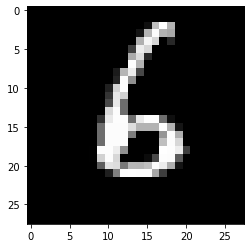

In [5]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

## Creating Model

In this section we will create a model with the help of `nn.Linear` from `tourch`.

In [6]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)    # To make each image as a flat vector
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                     # Generate prediction
        loss = F.cross_entropy(out, labels)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)            # Calculate Loss
        return {'val_loss': loss.detach(), "val_acc":acc.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_accs = torch.stack(batch_accs).mean()    # Combine accuracies
        return { "val_loss": epoch_loss.item(), "val_acc": epoch_accs.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result["val_acc"]))
        
model = MnistModel()

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Train the created Model an Evaluate

In this section, we will train our created model by the training data and validate its' performance. 

In [8]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Testing after initializtion of the model

In [9]:
evaluate(model, val_loader)

{'val_loss': 2.3163089752197266, 'val_acc': 0.06806640326976776}

In [10]:
history = fit(20, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9521, val_acc: 0.6159
Epoch [1], val_loss: 1.6817, val_acc: 0.7335
Epoch [2], val_loss: 1.4801, val_acc: 0.7676
Epoch [3], val_loss: 1.3278, val_acc: 0.7882
Epoch [4], val_loss: 1.2107, val_acc: 0.8012
Epoch [5], val_loss: 1.1186, val_acc: 0.8122
Epoch [6], val_loss: 1.0447, val_acc: 0.8204
Epoch [7], val_loss: 0.9841, val_acc: 0.8243
Epoch [8], val_loss: 0.9336, val_acc: 0.8289
Epoch [9], val_loss: 0.8909, val_acc: 0.8328
Epoch [10], val_loss: 0.8544, val_acc: 0.8363
Epoch [11], val_loss: 0.8227, val_acc: 0.8393
Epoch [12], val_loss: 0.7949, val_acc: 0.8428
Epoch [13], val_loss: 0.7703, val_acc: 0.8435
Epoch [14], val_loss: 0.7484, val_acc: 0.8454
Epoch [15], val_loss: 0.7288, val_acc: 0.8476
Epoch [16], val_loss: 0.7110, val_acc: 0.8491
Epoch [17], val_loss: 0.6949, val_acc: 0.8507
Epoch [18], val_loss: 0.6802, val_acc: 0.8521
Epoch [19], val_loss: 0.6667, val_acc: 0.8528


In [11]:
history = fit(10, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6654, val_acc: 0.8528
Epoch [1], val_loss: 0.6641, val_acc: 0.8532
Epoch [2], val_loss: 0.6629, val_acc: 0.8533
Epoch [3], val_loss: 0.6616, val_acc: 0.8534
Epoch [4], val_loss: 0.6604, val_acc: 0.8536
Epoch [5], val_loss: 0.6591, val_acc: 0.8541
Epoch [6], val_loss: 0.6579, val_acc: 0.8543
Epoch [7], val_loss: 0.6567, val_acc: 0.8543
Epoch [8], val_loss: 0.6555, val_acc: 0.8544
Epoch [9], val_loss: 0.6543, val_acc: 0.8545


Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

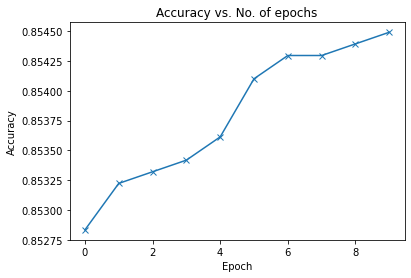

In [12]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. No. of epochs")

## Evaluate on Test set and make Prediction

In [13]:
result = evaluate(model, test_loader)
result

{'val_loss': 0.6303585171699524, 'val_acc': 0.8623046875}

So our testing result is `86.23% accuracy` which is not quite satisfying.

In [15]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 5 , Predicted:  5


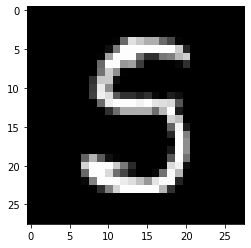

In [21]:
img, label = test_ds[5885]
plt.imshow(img[0],cmap="gray")
print("Label:",label, ", Predicted: ", predict_image(img, model))

Label: 7 , Predicted:  7


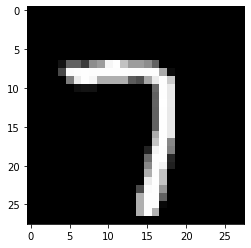

In [23]:
img, label = test_ds[585]
plt.imshow(img[0],cmap="gray")
print("Label:",label, ", Predicted: ", predict_image(img, model))

Label: 8 , Predicted:  5


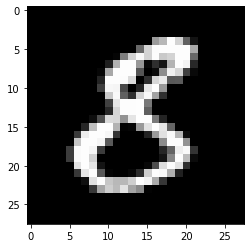

In [24]:
img, label = test_ds[1234]
plt.imshow(img[0],cmap="gray")
print("Label:",label, ", Predicted: ", predict_image(img, model))

Label: 0 , Predicted:  0


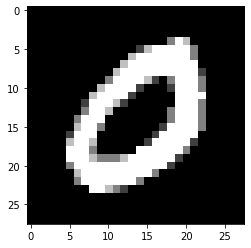

In [25]:
img, label = test_ds[8764]
plt.imshow(img[0],cmap="gray")
print("Label:",label, ", Predicted: ", predict_image(img, model))

## Save the model

In [22]:
torch.save(model.state_dict(), 'img_classifier-logistic.pth')